<a href="https://colab.research.google.com/github/AlmTechSoftware/piper/blob/research/training_data/research/feynman_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

## Dataset download from temporary 0x0.st

In [2]:
!curl http://0x0.st/HpsS.zip > dataset.zip
!ls dataset && rm -r dataset
!unzip dataset.zip -d dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.3M  100 11.3M    0     0  7174k      0  0:00:01  0:00:01 --:--:-- 7179k
ls: cannot access 'dataset': No such file or directory
Archive:  dataset.zip
   creating: dataset/valid/
  inflating: dataset/valid/20180910_153936_5b97bea9ddf2b358f90f884b_jpg.rf.bd21c8dd22ab72203e447876f98b8031.jpg  
  inflating: dataset/valid/EKF-UKF_jpg.rf.8806f6a948a6c61b96ed9d830d813753.jpg  
  inflating: dataset/valid/FqyewkjWwAE9ZsK_jpg.rf.dd1a8ab6b2d03fc455b512e8a6be8caf.jpg  
  inflating: dataset/valid/_annotations.coco.json  
  inflating: dataset/valid/D1D9CE52-103C-4BA1-A550-4F6F1018DC66_1_105_c-1_jpeg.rf.3ec235a322a99136a587c56039daa1db.jpg  
   creating: dataset/test/
  inflating: dataset/test/Adam-still_jpeg.rf.90fbaea30ed3e09fd7fda5aa92ea6a68.jpg  
  inflating: dataset/test/MPC_2_jpg.rf.8263fb9cbb0b86857de4519a380ac872.jpg  
  inflating:

## Dependencies

In [3]:
!pip install  opencv-python \
              scikit-image \
              python-dotenv \
              pycocotools \
              dataclasses-json \
              supervision \
              colored \
              wandb \
              torchvision \
              torchviz -Uq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.8/218.8 kB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


## WandB login

In [3]:
import wandb
wandb.login()

KeyboardInterrupt: ignored

# Definitions

## Dataset Handler Definition

In [4]:
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 8

In [5]:
!pip install pycocotools

In [6]:
import torchvision.transforms as T
_tensor_pil_transform = T.ToPILImage()

def tensor_to_pil(tensor):
    return _tensor_pil_transform(tensor)

In [35]:
import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO
from typing import Tuple, List
from PIL import Image
from collections import defaultdict as DD

import torchvision.transforms as transforms
import torchvision.transforms.functional as fun
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import cv2

import os

class CocoSegmentationDataset(Dataset):
    def __init__(self,
                 root_dir: str,
                 annotation_file: str,
                 do_transform: bool = True,
                 common_size: Tuple[int, int] = (512, 512),
                ):
        self.root_dir = root_dir
        self.common_size = common_size
        self.coco = COCO(annotation_file)
        self.image_ids = list(self.coco.imgs.keys())

        self.category_ids = self.coco.getCatIds()
        self.num_categories = len(self.category_ids)

        if do_transform:
            self.transform = transforms.Compose([
                transforms.Resize(self.common_size),
                transforms.ToTensor(),
            ])

        self.normalize = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.coco.getImgIds())

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = os.path.join(self.root_dir, image_info['file_name'])
        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        annotations = self.coco.loadAnns(ann_ids)

        image = Image.open(image_path).convert("RGB")

        masks = np.zeros((self.num_categories, *self.common_size), dtype=np.uint8)
        for ann in annotations:
            masks_buf = np.zeros((self.num_categories, *self.common_size), dtype=np.uint8)
            cat_id = ann["category_id"]
            mask = self.coco.annToMask(ann)
            mask = cv2.resize(mask, self.common_size, interpolation=cv2.INTER_NEAREST)
            masks_buf[cat_id - 1, :, :] = mask

            masks = np.maximum(masks_buf, masks)

        masks = torch.from_numpy(masks)

        if self.transform:
            image = self.transform(image)

        return image, masks

dataset = CocoSegmentationDataset(root_dir="dataset/train/",
                                  annotation_file="dataset/train/_annotations.coco.json")

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


imgs[0].shape=torch.Size([3, 512, 512]) masks[0].shape=torch.Size([3, 512, 512])


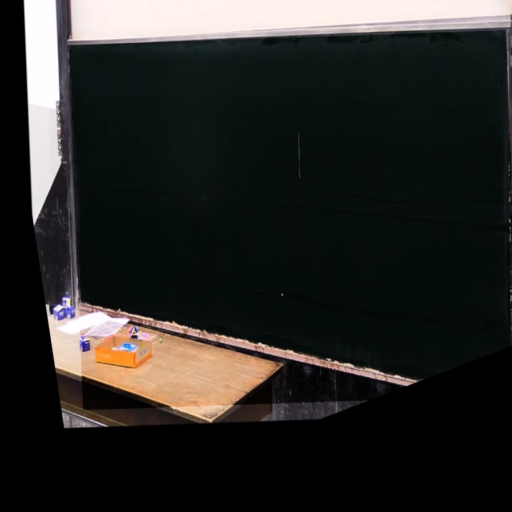

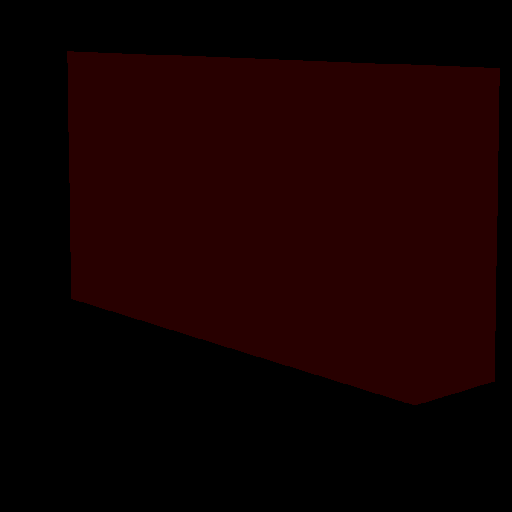

In [41]:
for batch in dataloader:
    imgs, masks = batch
    print(f"{imgs[0].shape=} {masks[0].shape=}")
    display(tensor_to_pil(imgs[0]))
    display(tensor_to_pil(masks[0] * 40))
    break

## FeynMAN Model Definition

In [43]:
import torch
import torch.nn as nn

from torch import Tensor

class FeynMAN(nn.Module):
    def __init__(self, in_channels: int = 3, num_classes: int = 2):
        super(__class__, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> Tensor:
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

# Training

In [44]:
!nvidia-smi && echo "YES YOU CAN TRAIN WITH CUDA!"

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim

def train_model(
    model: nn.Module,
    dataloader: DataLoader,
    epochs: int = EPOCHS,
    batch_size: int = BATCH_SIZE,
    learning_rate: float = LEARNING_RATE,
    device: torch.device = torch.device("cpu"),
):
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="feynman_2",

        # track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "epochs": epochs,
        "batch_size": batch_size,
        "architecture": "FeynMAN",
        "dataset": "feynman_v7i",
        }
    )

    # Watch the model for cool weights & biases
    wandb.watch(model)

    # criterion = nn.CrossEntropyLoss() # nn.BCELoss() #### TODO: change?
    criterion = nn.BCELoss()
    params = model.parameters()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # dataset = PNGMaskDataset(dataset_dir)
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    print("BEGIN TRAINING!")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(epoch)

        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device) #.float()
            print("#", batch_idx)

            # Forward pass
            outputs = model(images)
            print("post forward pass")
            loss = criterion(outputs, masks)
            print("loss done")

            # Backpropagation and optimization
            optimizer.zero_grad()
            print("zero grad done")
            loss.backward()
            print("backward done")
            optimizer.step()
            print("step done")

            running_loss += loss.item()
            wandb.log({"Loss": loss})

            print(
                f"Epoch [{epoch+1}/{epochs}] Batch [{batch_idx+1}/{len(dataloader)}] - Loss: {loss:.4f}"
            )

        wandb.log({"Running loss": running_loss})

    print("END TRAINING!")
    wandb.finish()

### Model creation

In [ ]:
model = FeynMAN()
device_type = "cuda" if torch.cuda.is_available() else "cpu"
#device_type = "cpu"
device = torch.device(device_type)

# Put the model on the GPU
model = model.to(device)

#### Debug

In [ ]:
# Test the input etc.

input_height = 256
input_width = 256
random_input = torch.randn(1, 3, input_height, input_width)

# Forward pass
segmentation_map = model(random_input)
print("Segmentation map shape:", segmentation_map.shape)

Segmentation map shape: torch.Size([1, 3, 256, 256])


In [ ]:
from torchviz import make_dot

ds = PNGMaskDataset("./dataset/test/")
x_tmp, _ = ds[0]
x_tmp = x_tmp.to(device)
y_tmp = model(x_tmp.unsqueeze(0))

make_dot(y_tmp, params=dict(list(model.named_parameters()))).render("model.png", format="png")

del model, ds, x_tmp, y_tmp, _

In [ ]:
!pip install torchsummary


model = model.to(device)

from torchsummary import summary
summary(model, input_size=(3, 128, 128), batch_size=8, device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 128, 128]           1,792
              ReLU-2          [8, 64, 128, 128]               0
            Conv2d-3         [8, 128, 128, 128]          73,856
              ReLU-4         [8, 128, 128, 128]               0
            Conv2d-5         [8, 256, 128, 128]         295,168
              ReLU-6         [8, 256, 128, 128]               0
            Conv2d-7           [8, 3, 128, 128]             771
Total params: 371,587
Trainable params: 371,587
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.50
Forward/backward pass size (MB): 899.00
Params size (MB): 1.42
Estimated Total Size (MB): 901.92
----------------------------------------------------------------


### Start training loop

#### FCN ResNet 50 test

In [ ]:
from torchvision.models.segmentation import fcn_resnet50

model = fcn_resnet50(num_classes=3, pretrained=False)
model = model.to(device)

#### Train the model

In [ ]:
# Fix for some CUDA bullshit

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
print(f"Doing training on device type '{device_type}'!")
torch.cuda.empty_cache()
train_model(model, dataloader=dataloader, device=device, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE, epochs=EPOCHS)

Doing training on device type 'cuda'!


BEGIN TRAINING!
0


KeyError: ignored